# Setup

In [1]:
DATA_FILE_NAME = "consultation-documents-preprocessed-2024-11-26.parquet"

DOCUMENT_SOURCES = {
    "fedlex",
    "openparldata",
}
LANGUAGES = {
    "de",
    # "fr",
    # "it",
}

# EMBEDDING_MODEL = "openai/text-embedding-ada-002"
EMBEDDING_MODEL = "openai/text-embedding-3-large"

# FROM_YEAR = 2010
FROM_YEAR = 2000

MIN_CONSULTATIONS_IN_CLASS = 50
IGNORE_TOPICS = {
    # "administration",
    # "communications",
}

DOC_TYPES = {
    # "LETTER",
    "DRAFT",
    # "RECIPIENT_LIST",  # proven to not be useful
    # "REPORT",
    # "FINAL_REPORT",
    # "OPINION",
    # "VARIOUS_TEXT",
    # "SYNOPTIC_TABLE",  # possibly not useful?
    # "SURVEY",
    # "RESPONSE_FORM",
    None,  # Many openparldata documents don't have a known type
}

CV_FOLDS = 5
TEST_SIZE = 0.1
RANDOM_STATE = 271
USE_TEST_SET = False

%env MLFLOW_TRACKING_URI=sqlite:///mlruns.db

env: MLFLOW_TRACKING_URI=sqlite:///mlruns.db


In [2]:
%load_ext autoreload
%autoreload 2

import logging
import pathlib
import sys

import dotenv
import mlflow
import numpy as np
import sklearn.metrics
import sklearn.model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

REPOSITORY_ROOT = (pathlib.Path().cwd() / ".." / "..").resolve()
sys.path.append(str(REPOSITORY_ROOT))

In [3]:
from research.lib import data_access, data_transformations, embeddings, plotting, stratified_group_split

In [4]:
dotenv.load_dotenv()

True

In [5]:
mlflow.set_experiment(f"V1. {'&'.join(sorted(LANGUAGES))}. document topics")

if run := mlflow.active_run():
    logging.warning("Run = %s is already active, closing it.", run.info.run_name)
    mlflow.end_run()
run = mlflow.start_run()
print("Starting run:", run.info.run_name)
mlflow.log_param("input_file", DATA_FILE_NAME)
mlflow.log_param("document_sources", sorted(DOCUMENT_SOURCES))
mlflow.log_param("languages", LANGUAGES)
mlflow.log_param("from_year", FROM_YEAR)
mlflow.log_param("min_consultations_in_class", MIN_CONSULTATIONS_IN_CLASS)
mlflow.log_param("ignore_topics", sorted(IGNORE_TOPICS))
mlflow.log_param("doc_types", sorted(map(str, DOC_TYPES)))
mlflow.log_param("embedding_model", EMBEDDING_MODEL)
mlflow.log_param("cv_folds", CV_FOLDS)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("random_state", RANDOM_STATE)
;

Starting run: victorious-bug-203


''

In [6]:
mlflow.sklearn.autolog()
tqdm.pandas()

# Input data preparation

In [7]:
PREPROCESSED_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / DATA_FILE_NAME
data_access.ensure_dataframe_is_available(PREPROCESSED_DATA_FILE)

In [8]:
df_docs = data_access.load_consultation_documents(
    PREPROCESSED_DATA_FILE,
    only_document_sources=DOCUMENT_SOURCES,
    only_languages=LANGUAGES,
    only_doc_types=DOC_TYPES,
    starting_year=FROM_YEAR,
    mlflow=mlflow,
)
df_docs

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/mlflow/data/dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '/Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-preprocessed-2024-11-26.parquet'. Exception: 
  return _dataset_source_registry.resolve(
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/mlflow/data/dataset_source_registry.py:149: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input da

,document_id,consultation_id,consultation_start_date,consultation_end_date,consultation_title,consultation_description,document_source_url,consultation_url,consultation_topics,document_type,document_language,document_title,organisation_id,organisation_name,political_body,consultation_reviewed_at,document_source,consultation_topics_label_source,document_content_plain
0,1,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]",DRAFT,de,Vernehmlassungsvorlage,41,Bundesamt für Zoll und Grenzsicherheit,ch,2024-11-04 15:11:24,fedlex,manual,«$$e-seal» \n«$$QrCode» \n \n2021-… \n«%ASFF_Y...
21,22,2,2021-12-03,2022-03-18,Änderung der Verordnung über Fernmeldedienste ...,In Vollzug von Artikel 48a FMG über die Sicher...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/a49pncfq,[communications],DRAFT,de,Vernehmlassungsvorlage,38,Bundesamt für Kommunikation,ch,NaT,fedlex,organisation_rule,[Signature] \n[QR Code] \n \n1 \nVerordnung \n...
42,43,3,2021-10-11,2022-01-25,"Teilrevisionen der Raumplanungsverordnung, der...","Das Eidgenössische Departement für Umwelt, Ver...",https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/tcspwfam,[energy],DRAFT,de,Vernehmlassungsvorlage EnEV,44,Bundesamt für Energie,ch,NaT,fedlex,organisation_rule,2021-… \n \nVerordnung \n \n \n \nVernehmlass...
51,52,3,2021-10-11,2022-01-25,"Teilrevisionen der Raumplanungsverordnung, der...","Das Eidgenössische Departement für Umwelt, Ver...",https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/tcspwfam,[energy],DRAFT,de,Vernehmlassungsvorlage RPV,44,Bundesamt für Energie,ch,NaT,fedlex,organisation_rule,1 \nRaumplanungsverordnung \n \nVernehmlassung...
54,55,3,2021-10-11,2022-01-25,"Teilrevisionen der Raumplanungsverordnung, der...","Das Eidgenössische Departement für Umwelt, Ver...",https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/tcspwfam,[energy],DRAFT,de,Vernehmlassungsvorlage NIV,44,Bundesamt für Energie,ch,NaT,fedlex,organisation_rule,2021-… \n \nVerordnung \n \n \n \nVernehmlass...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51926,53052,4830,2024-11-13,2025-03-03,Änderung der Arbeitslosenversicherungsverordnu...,Im Rahmen der laufenden Revision des AVIG das ...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/k3h5abdz,"[administration, economics, insurance]",DRAFT,de,Vernehmlassungsvorlage-2,90,Staatssekretariat für Wirtschaft,ch,2024-11-14 14:12:30,fedlex,manual,«$$e-seal» \n«$$QrCode» \n \nVorentwurf \n \n2...
51947,53073,4931,2024-11-13,2025-02-27,Anpassungen an den Internationalen Gesundheits...,Die IGV (2005) regeln die internationale Zusam...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/6ajdyn89,"[foreign_policy, health, security]",DRAFT,de,Vernehmlassungsvorlage,36,Bundesamt für Gesundheit,ch,2024-11-14 14:15:58,fedlex,manual,Vorläufige Übersetzung \n \n \n \nINTERNATION...
51967,53093,4950,2024-11-12,2024-12-16,Teilrevision des Gesetzes über die Förderung d...,Aufgrund der sich stetig verschlechternden fin...,https://www.gr.ch/DE/publikationen/vernehmlass...,https://www.demokratis.ch/vernehmlassung/cs8cj72s,"[health, public_finance, social]",DRAFT,de,Erlass,150,Regierung des Kantons Graubünden,gr,2024-11-14 14:20:06,openparldata,manual,AGS [Fundst. od. Gesch.-Nr.] \nGesetz über di...
51982,53108,4951,2024-11-12,2025-02-28,Revision des Gemeindegesetzes (GG),Gemäss dem geltenden Gemeindegesetz müssen Ein...,https://www.notes.zh.ch/sk/VNL/vnl.nsf/vw-alld...,https://www.demokratis.ch/vernehmlassung/addxwwjb,"[administration, public_finance]",DRAFT,de,Vorentwurf mit erläuterndem Be

## Create synthetic "documents" from consultation titles, descriptions, org names...

In [9]:
df_consultations_synthetic = data_transformations.create_synthetic_documents_from_consultations(df_docs)
df_consultations_synthetic

,consultation_id,consultation_start_date,consultation_end_date,consultation_url,consultation_topics,consultation_topics_label_source,consultation_reviewed_at,organisation_id,political_body,document_id,document_source,document_source_url,document_language,document_title,document_type,document_content_plain,organisation_name,consultation_title,consultation_description
0,1,2021-10-01,2022-01-17,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]",manual,2024-11-04 15:11:24,41,ch,-1,fedlex,https://fedlex.data.admin.ch/filestore/fedlex....,de,None,organisation_name,Bundesamt für Zoll und Grenzsicherheit,<synthetic>,<synthetic>,<synthetic>
1,2,2021-12-03,2022-03-18,https://www.demokratis.ch/vernehmlassung/a49pncfq,[communications],organisation_rule,NaT,38,ch,-1,fedlex,https://fedlex.data.admin.ch/filestore/fedlex....,de,None,organisation_name,Bundesamt für Kommunikation,<synthetic>,<synthetic>,<synthetic>
2,3,2021-10-11,2022-01-25,https://www.demokratis.ch/vernehmlassung/tcspwfam,[energy],organisation_rule,NaT,44,ch,-1,fedlex,https://fedlex.data.admin.ch/filestore/fedlex....,de,None,organisation_name,Bundesamt für Energie,<synthetic>,<synthetic>,<synthetic>
3,4,2021-11-24,2022-03-10,https://www.demokratis.ch/vernehmlassung/y9vpep78,[energy],organisation_rule,NaT,44,ch,-1,fedlex,https://fedlex.data.admin.ch/filestore/fedlex....,de,None,organisation_name,Bundesamt für Energie,<synthetic>,<synthetic>,<synthetic>
4,5,2021-12-10,2022-03-24,https://www.demokratis.ch/vernehmlassung/x7985bkz,[economics],organisation_rule,NaT,90,ch,-1,fedlex,https://fedlex.data.admin.ch/filestore/fedlex....,de,None,organisation_name,Staatssekretariat für Wirtschaft,<synthetic>,<synthetic>,<synthetic>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5584,4948,2024-11-07,2025-01-17,https://www.demokratis.ch/vernehmlassung/cve3225h,"[administration, housing, spatial_planning]",manual,2024-11-11 12:42:18,156,sg,-1,openparldata,https://www.sg.ch/news/sgch_allgemein/2024/11/...,de,None,consultation_description,Das amtliche Schätzungswesen soll in Teilen üb...,<synthetic>,<synthetic>,<synthetic>
5585,4949,2024-11-07,2025-02-14,https://www.demokratis.ch/vernehmlassung/wt6b7xbh,"[administration, economics, education]",manual,2024-11-11 12:38:32,166,zh,-1,openparldata,https://www.notes.zh.ch/sk/VNL/vnl.nsf/vw-alld...,de,None,consultation_description,In den Richtlinien der Regierungspolitik für d...,<synthetic>,<synthetic>,<synthetic>
5586,4950,2024-11-12,2024-12-16,https://www.demokratis.ch/vernehmlassung/cs8cj72s,"[health, public_finance, social]",manual,2024-11-14 14:20:06,150,gr,-1,openparldata,https://www.gr.ch/DE/publikationen/vernehmlass...,de,None,consultation_description,Aufgrund der sich stetig verschlechternden fin...,<synthetic>,<synthetic>,<synthetic>
5587,4951,2024-11-12,2025-02-28,https://www.demokratis.ch/vernehmlassung/addxwwjb,"[administration, public_finance]",manual,2024-11-14 14:25:43,166,zh,-1,openparldata,https://www.notes.zh.ch/sk/VNL/vnl.nsf/vw-alld...,de,None,consultation_description,Gemäss dem geltenden Gemeindegesetz müssen Ein...,<synthetic>,<synthetic>,<synthetic>


## Create the input dataframe

In [10]:
df_input, topic_columns = data_transformations.create_input_dataframe(
    df_docs,
    df_consultations_synthetic,
)
df_input

Dropping 22 documents with empty text.


,document_id,consultation_id,consultation_start_date,consultation_end_date,consultation_title,consultation_description,document_source_url,consultation_url,consultation_topics,document_type,...,topic_media,topic_migration,topic_political_system,topic_public_finance,topic_science,topic_security,topic_social,topic_spatial_planning,topic_sports,topic_transportation
0,1,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]",DRAFT,...,0,0,0,0,0,1,0,0,0,0
1,22,2,2021-12-03,2022-03-18,Änderung der Verordnung über Fernmeldedienste ...,In Vollzug von Artikel 48a FMG über die Sicher...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/a49pncfq,[communications],DRAFT,...,0,0,0,0,0,0,0,0,0,0
2,43,3,2021-10-11,2022-01-25,"Teilrevisionen der Raumplanungsverordnung, der...","Das Eidgenössische Departement für Umwelt, Ver...",https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/tcspwfam,[energy],DRAFT,...,0,0,0,0,0,0,0,0,0,0
3,52,3,2021-10-11,2022-01-25,"Teilrevisionen der Raumplanungsverordnung, der...","Das Eidgenössische Departement für Umwelt, Ver...",https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/tcspwfam,[energy],DRAFT,...,0,0,0,0,0,0,0,0,0,0
4,55,3,2021-10-11,2022-01-25,"Teilrevisionen der Raumplanungsverordnung, der...","Das Eidgenössische Departement für Umwelt, Ver...",https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/tcspwfam,[energy],DRAFT,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8492,-1,4948,2024-11-07,2025-01-17,<synthetic>,<synthetic>,https://www.sg.ch/news/sgch_allgemein/2024/11/...,https://www.demokratis.ch/vernehmlassung/cve3225h,"[administration, housing, spatial_planning]",consultation_description,...,0,0,0,0,0,0,0,1,0,0
8493,-1,4949,2024-11-07,2025-02-14,<synthetic>,<synthetic>,https://www.notes.zh.ch/sk/VNL/vnl.nsf/vw-alld...,https://www.demokratis.ch/vernehmlassung/wt6b7xbh,"[administration, economics, education]",consultation_description,...,0,0,0,0,0,0,0,0,0,0
8494,-1,4950,2024-11-12,2024-12-16,<synthetic>,<synthetic>,https://www.gr.ch/DE/publikationen/vernehmlass...,https://www.demokratis.ch/vernehmlassung/cs8cj72s,"[health, public_finance, social]",consultation_description,...,0,0,0,1,0,0,1,0,0,0
8495,-1,4951,2024-11-12,2025-02-28,<synthetic>,<synthetic>,https://www.notes.zh.ch/sk/VNL/vnl.nsf/vw-alld...,https://www.demokratis.ch/vernehmlassung/addxwwjb,"[administration, public_finance]",consultation_description,...,0,0,0,1,0,0,0,0,0,0


## Drop underrepresented topics

In [11]:
df_input, topic_columns = data_transformations.drop_underrepresented_topics(
    df_input,
    topic_columns,
    MIN_CONSULTATIONS_IN_CLASS,
    always_drop_topics=IGNORE_TOPICS,
)

Dropping these underrepresented classes:
 topic_culture             18
topic_housing             22
topic_media                8
topic_political_system     4
topic_sports              27
dtype: int64
Dropping these documents without any label: 121


In [12]:
print("Original number of documents:", df_docs.shape[0])
print("Original number of consultations:", df_docs["consultation_id"].nunique())
print("\ndf_input size (documents):", df_input.shape[0])
print("df_input size (consultations):", df_input["consultation_id"].nunique())

Original number of documents: 2908
Original number of consultations: 1863

df_input size (documents): 8354
df_input size (consultations): 1837


## Splits

### Set aside a test set

In [13]:
splitter = stratified_group_split.MultilabelStratifiedGroupShuffleSplit(
    n_splits=1,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

train_index, test_index = next(splitter.split(df_input, df_input[topic_columns], groups=df_input["consultation_id"]))

In [14]:
df_input_train = df_input.iloc[train_index]
df_input_test = df_input.iloc[test_index]

print("Train:", df_input_train.shape)
print("Test:", df_input_test.shape)

Train: (7520, 40)
Test: (834, 40)


In [15]:
assert not set(df_input_train["consultation_id"]) & set(
    df_input_test["consultation_id"]
), "No leakage between train and test sets"

In [16]:
mlflow.log_param("train_samples_count", len(df_input_train))
mlflow.log_param("test_samples_count", len(df_input_test))

834

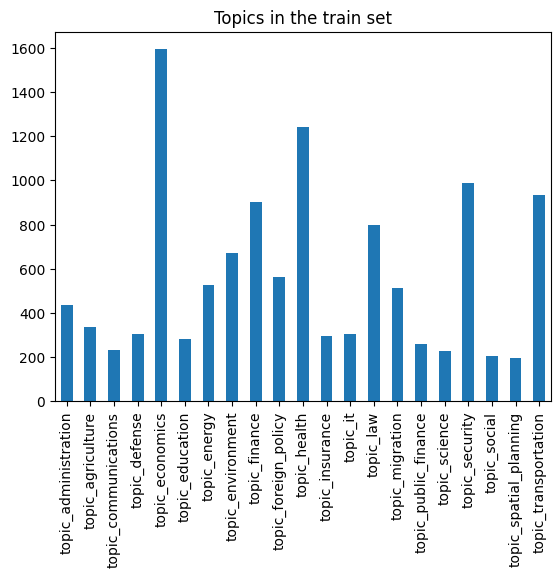

In [17]:
plotting.plot_and_log(
    df_input_train[topic_columns].sum().plot.bar,
    "figures/topics-counts-train.png",
    title="Topics in the train set",
)

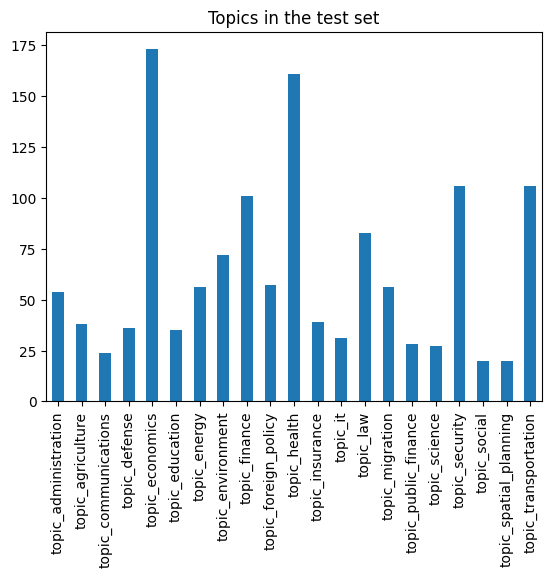

In [18]:
plotting.plot_and_log(
    df_input_test[topic_columns].sum().plot.bar,
    "figures/topics-counts-test.png",
    title="Topics in the test set",
)

### Prepare a cross-validation splitter

In [19]:
cv_splitter = stratified_group_split.MultilabelStratifiedGroupKFold(
    n_splits=CV_FOLDS,
    shuffle=True,
    random_state=RANDOM_STATE,
)

# Embeddings

## Tokenise and truncate to input window

In [20]:
embedding_model = embeddings.create_embedding_model(EMBEDDING_MODEL)
mlflow.log_param("embedding_model.max_input_tokens", embedding_model.max_input_tokens)

tokens_train = df_input_train["document_content_plain"].progress_map(embedding_model.tokenize)
tokens_test = df_input_test["document_content_plain"].progress_map(embedding_model.tokenize)

100%|██████████| 834/834 [00:00<00:00, 1308.63it/s]


## Embed

In [21]:
with embeddings.use_cache(
    embedding_model,
    tqdm=tqdm,
    cache_directory=REPOSITORY_ROOT / "data" / "embeddings-cache",
) as get_embeddings:
    embeddings_train = get_embeddings(tokens_train.tolist())
    print(embeddings_train.shape)
    embeddings_test = get_embeddings(tokens_test.tolist())
    print(embeddings_test.shape)

Embedding (cached=7519, new=0): 100%|██████████| 7520/7520 [00:03<00:00, 2300.46it/s]


(7520, 3072)


Embedding (cached=833, new=0): 100%|██████████| 834/834 [00:00<00:00, 1995.46it/s]


(834, 3072)


# Classification

In [22]:
X_train = embeddings_train
X_test = embeddings_test

y_train = df_input_train[topic_columns]
y_test = df_input_test[topic_columns]

groups_train = df_input_train["consultation_id"]
groups_test = df_input_test["consultation_id"]

print("Train", X_train.shape, y_train.shape)
print("Test", X_test.shape, y_test.shape)

Train (7520, 3072) (7520, 21)
Test (834, 3072) (834, 21)


In [23]:
classifier = make_pipeline(
    StandardScaler(),
    # PCA(n_components=200, random_state=RANDOM_STATE),
    MultiOutputClassifier(
        LogisticRegression(max_iter=1000),
    ),
)

classifier

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('multioutputclassifier',
                 MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000)))])

In [24]:
if "pca" in classifier.named_steps:
    mlflow.log_param("pca_n_components", classifier.named_steps["pca"].get_params()["n_components"])
mlflow.log_param(
    "classifier",
    classifier.named_steps["multioutputclassifier"].estimator.__class__.__name__,
)

'LogisticRegression'

In [25]:
def explained_variance_scorer(pipeline, X, y=None) -> np.float64:
    """If PCA is used in the pipeline, include its explained variance in scores."""
    try:
        pca = pipeline.named_steps["pca"]
    except KeyError:
        return np.nan
    explained_variance = np.sum(pca.explained_variance_ratio_)
    return explained_variance


scoring = {
    "precision": "precision_samples",
    "recall": "recall_samples",
    "f1": "f1_samples",
    "pca_explained_variance": explained_variance_scorer,
}

scores_docs = sklearn.model_selection.cross_validate(
    classifier,
    X=X_train,
    y=y_train,
    groups=groups_train,
    cv=cv_splitter,
    scoring=scoring,
)
scores_docs

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf

{'fit_time': array([20.45023704, 20.24301219, 21.71658373, 21.21849084, 21.80906701]),
 'score_time': array([0.06866503, 0.06541109, 0.06982517, 0.06543207, 0.06796002]),
 'test_precision': array([0.73346783, 0.72596047, 0.75280206, 0.75309058, 0.74270166]),
 'test_recall': array([0.71346111, 0.71696647, 0.73996862, 0.73229939, 0.72737943]),
 'test_f1': array([0.69807698, 0.69447353, 0.71985782, 0.71510612, 0.71088806]),
 'test_pca_explained_variance': array([nan, nan, nan, nan, nan])}

## Evaluation of the cross-validation

In [26]:
avg_scores_docs = {k: np.round(np.mean(v), 4) for k, v in scores_docs.items()}
mlflow.log_metrics({f"{k}_docs": v for k, v in avg_scores_docs.items() if k.startswith("test_")})

print("Per-document CV scores:")
print(f"Precision: {avg_scores_docs['test_precision']:.4f} (+/- {np.std(scores_docs['test_precision']):.4f})")
print(f"Recall:    {avg_scores_docs['test_recall']:.4f} (+/- {np.std(scores_docs['test_recall']):.4f})")
print(f"F1:        {avg_scores_docs['test_f1']:.4f} (+/- {np.std(scores_docs['test_f1']):.4f})")

Per-document CV scores:
Precision: 0.7416 (+/- 0.0107)
Recall:    0.7260 (+/- 0.0098)
F1:        0.7077 (+/- 0.0098)


### Use subsets of the training set to re-train and evaluate. This gives us a single model to run reports on. 

Split the training set into 'CV training' and 'CV testing' sets so we still don't have to touch our real test set.

In [27]:
cv_test_splitter = stratified_group_split.MultilabelStratifiedGroupShuffleSplit(
    n_splits=1,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

cv_train, cv_test = stratified_group_split.one_simple_split(
    splitter,
    X=X_train,
    y=y_train,
    groups=groups_train,
)

print("CV train:", cv_train.shapes)
print("CV test:", cv_test.shapes)

CV train: ((6826, 3072), (6826, 21))
CV test: ((694, 3072), (694, 21))


2024/12/02 16:12:46 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'DataFrame' object has no attribute 'flatten'
2024/12/02 16:13:10 WARNING mlflow.sklearn.utils: log_loss failed. The metric training_log_loss will not be recorded. Metric error: Found array with dim 3. None expected <= 2.
2024/12/02 16:13:10 WARNING mlflow.sklearn.utils: roc_auc_score failed. The metric training_roc_auc will not be recorded. Metric error: Found array with dim 3. None expected <= 2.
2024/12/02 16:13:10 WARNING mlflow.sklearn.utils: _get_classifier_artifacts.<locals>.plot_confusion_matrix failed. The artifact training_confusion_matrix will not be recorded. Artifact error: multilabel-indicator is not supported
2024/12/02 16:13:12 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


docs: ground truth (694, 21)
docs: predictions (694, 21)
consultations: ground truth (156, 21)
consultations: predictions (156, 21)


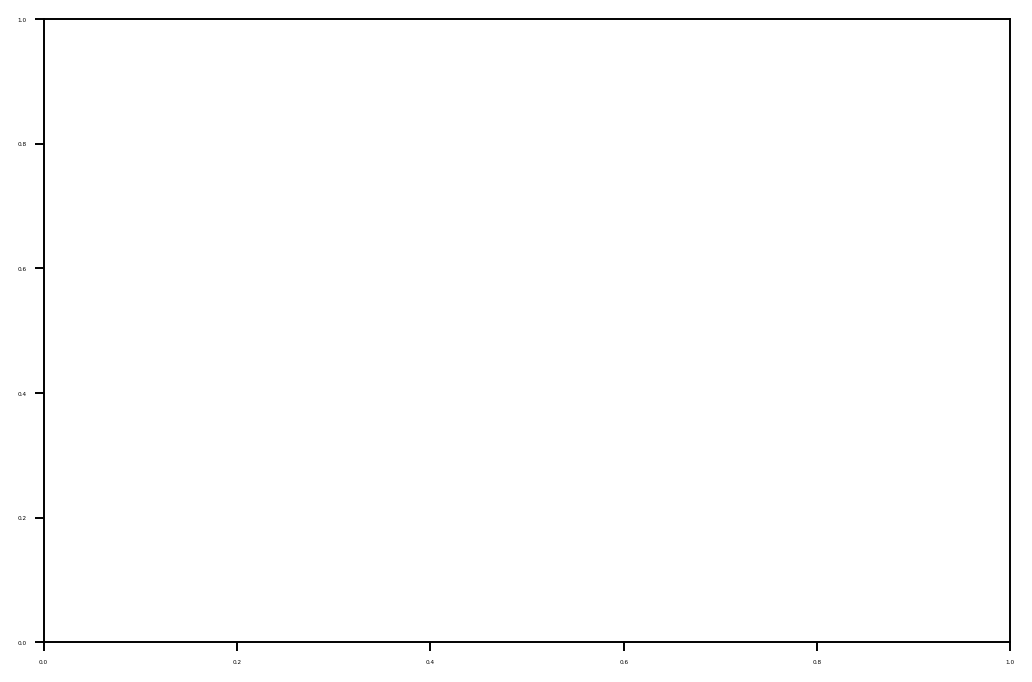

In [28]:
# Train the classifier on the CV train set - documents
classifier.fit(cv_train.X, cv_train.y)
# Get our ground truth - documents
cv_test_ground_truth_docs = cv_test.y
# Predict on the CV test set - documents
cv_test_predictions_docs = classifier.predict(cv_test.X)
assert isinstance(cv_test_predictions_docs, np.ndarray)

# Convert our per-document ground truth to consultations
cv_test_ground_truth_consultations = data_transformations.group_document_labels_by_consultation(
    consultation_ids=cv_test.groups,
    label_names=topic_columns,
    doc_labels=cv_test_ground_truth_docs,
)
# Convert our per-document predictions to consultations
cv_test_predictions_consultations = data_transformations.group_document_labels_by_consultation(
    consultation_ids=cv_test.groups,
    label_names=topic_columns,
    doc_labels=cv_test_predictions_docs,
)

print("docs: ground truth", cv_test_ground_truth_docs.shape)
print("docs: predictions", cv_test_predictions_docs.shape)
print("consultations: ground truth", cv_test_ground_truth_consultations.shape)
print("consultations: predictions", cv_test_predictions_consultations.shape)

In [29]:
precision, recall, f1, _ = sklearn.metrics.precision_recall_fscore_support(
    cv_test_ground_truth_consultations,
    cv_test_predictions_consultations,
    average="samples",
)
scores_consultations = {
    "test_precision": precision,
    "test_recall": recall,
    "test_f1": f1,
}
mlflow.log_metrics(scores_consultations)
print("Per consultation scores:")
print(f"Precision: {scores_consultations['test_precision']:.4f}")
print(f"Recall:    {scores_consultations['test_recall']:.4f}")
print(f"F1:        {scores_consultations['test_f1']:.4f}")

Per consultation scores:
Precision: 0.8511
Recall:    0.8114
F1:        0.8047


/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


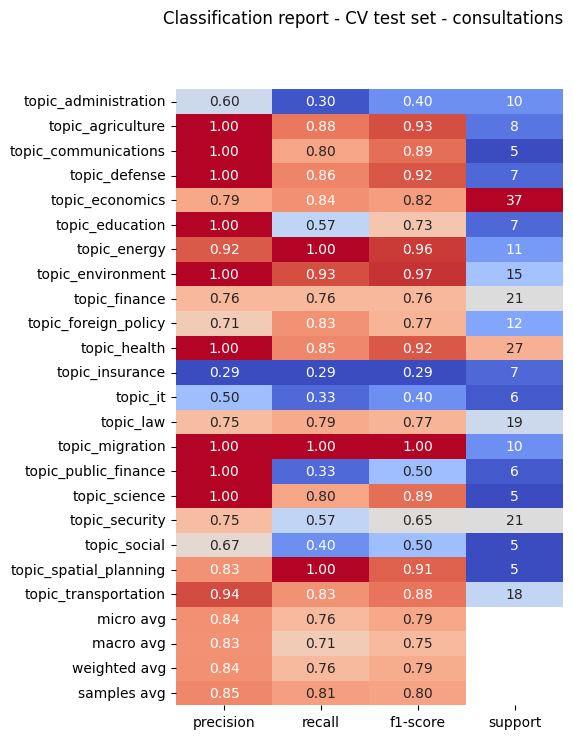

In [30]:
fig = plotting.plot_classification_report_heatmap(
    cv_test_ground_truth_consultations.values,
    cv_test_predictions_consultations.values,
    target_names=topic_columns,
)
fig.suptitle("Classification report - CV test set - consultations")
mlflow.log_figure(fig, "classification_report_heatmap_cv_test.png")
fig

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


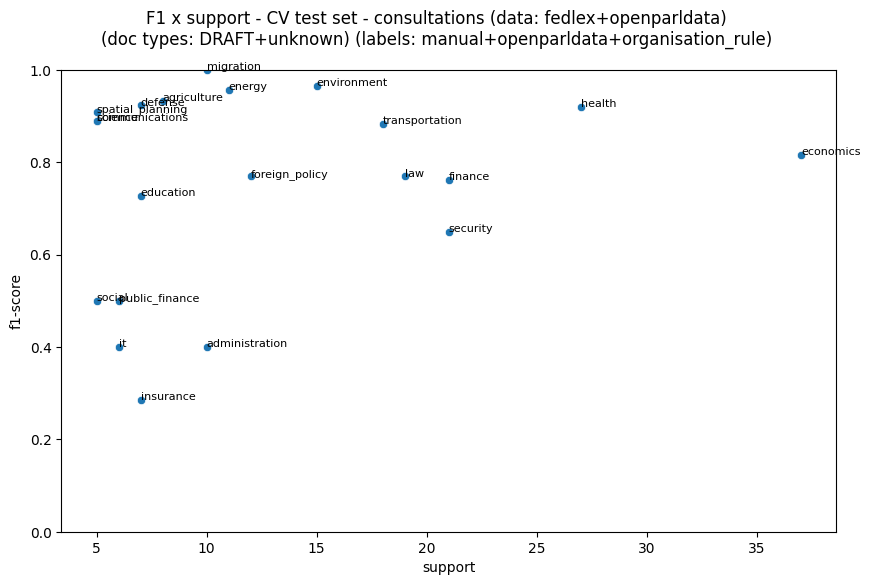

In [31]:
fig = plotting.plot_score_against_support(
    cv_test_ground_truth_consultations.values,
    cv_test_predictions_consultations.values,
    target_names=topic_columns,
)
document_sources = "+".join(sorted(DOCUMENT_SOURCES))
document_types = "+".join(sorted(t if t else "unknown" for t in DOC_TYPES))
label_sources = "+".join(sorted(df_input["consultation_topics_label_source"].unique()))
fig.suptitle(
    "\n".join(
        [
            f"F1 x support - CV test set - consultations (data: {document_sources})",
            f"(doc types: {document_types}) (labels: {label_sources})",
        ]
    )
)
mlflow.log_figure(fig, "classification_report_score_against_support_cv_test.png")
fig

***

## Evaluation on the test set (USE SPARINGLY)

In [32]:
if USE_TEST_SET:
    classifier.fit(X_train, y_train)
    test_ground_truth_docs = y_test
    test_predictions_docs = classifier.predict(X_test)

    test_ground_truth_consultations = data_transformations.group_document_labels_by_consultation(
        df_input_test["consultation_id"], topic_columns, y_test.values
    )
    test_predictions_consultations = data_transformations.group_document_labels_by_consultation(
        df_input_test["consultation_id"], topic_columns, test_predictions_docs
    )

    print("docs: ground truth", test_ground_truth_docs.shape)
    print("docs: predictions", test_predictions_docs.shape)
    print("consultations: ground truth", test_ground_truth_consultations.shape)
    print("consultations: predictions", test_predictions_consultations.shape)

In [33]:
if USE_TEST_SET:
    precision, recall, f1, _ = sklearn.metrics.precision_recall_fscore_support(
        test_ground_truth_consultations,
        test_predictions_consultations,
        average="samples",
    )
    scores_consultations = {
        "test_precision": precision,
        "test_recall": recall,
        "test_f1": f1,
    }
    mlflow.log_metrics(scores_consultations)
    print("Per consultation scores:")
    print(f"Precision: {scores_consultations['test_precision']:.4f}")
    print(f"Recall:    {scores_consultations['test_recall']:.4f}")
    print(f"F1:        {scores_consultations['test_f1']:.4f}")

In [34]:
if USE_TEST_SET:
    fig = plotting.plot_classification_report_heatmap(
        test_ground_truth_consultations,
        test_predictions_consultations,
        target_names=topic_columns,
    )
    fig.suptitle("Classification report - test set - consultations")
    mlflow.log_figure(fig, "classification_report_heatmap_test.png")
    display(fig)

***

# End MLflow run

In [35]:
mlflow.end_run()